In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from rigaku_smartlab.dataset import *
import xrayutilities as xu

In [2]:
def reciprocal_space_map_1D(list_files, use_rlu, xlim = None, ylim = None, 
    grid_size = 512, dyn_low = 4, dyn_high = 0, levels = 15, label_size = 20, 
    title = 'Reciprocal Space Map (1D)'):
    """
    Function to create a 1D RSM from a list of files

    Parameters
    ----------
    list_files : list
        List of files to be processed
    use_rlu : bool
        If True, use RLU coordinates
    xlim: tuple (optional)
        X-axis limits for the plot (RLU coordinates)
    ylim: tuple (optional)
        Y-axis limits for the plot (RLU coordinates)
    grid_size : int
        Size of the grid for the reciprocal space map, default is 512
    dyn_low : int
        Lower dynamic range limit for the color map, default is 4
    dyn_high : int
        Upper dynamic range limit for the color map, default is 0
    levels : int (optional)
        Number of levels for the contour plot, default is 15
    label_size : int
        Size of the labels in the plot
    title : str
        Title of the plot, default is 'Reciprocal Space Map (1D)'
    """    

    # Read the data from list of files
    [omega, two_theta], data = xu.io.getras_scan(
        list_files, None, 'Omega', 'TwoTheta',
    )

    # Get the 2D grid based on unique values of omega and two theta
    grid_angular = xu.Gridder2D(len(np.unique(omega)), len(np.unique(two_theta)))
    grid_angular(omega, two_theta, data['int'])

    # Plot initialization
    plt.figure(figsize=(7.5, 8), dpi=600)   

    if use_rlu:
        # Define the Q vectors for the Si material and initialize the HR-XRD object
        Si = xu.materials.Si
        hxrd = xu.HXRD(
            Si.Q(1, 1, -2), Si.Q(1, 1, 1), wl = xu.config.WAVELENGTH,
        )

        # Initialize the Gridder2D object for RLU coordinates
        grid_reciprocal = xu.Gridder2D(grid_size, grid_size)

        # Get the Qy and Qz values for the reciprocal space map
        [_, Qy, Qz] = hxrd.Ang2Q(omega, two_theta)

        # Fill the grid with the intensity data
        grid_reciprocal(Qy, Qz, data['int'])

        # Set the limits for the color map       
        intensity_reciprocal = xu.maplog(
            grid_reciprocal.data.transpose(), dyn_low, dyn_high
        )

        # Plot the reciprocal space map (in RLU coordinates)
        cf = plt.contour(
            grid_reciprocal.xaxis / (2 * np.pi) * 10, 
            grid_reciprocal.yaxis / (2 * np.pi) * 10, 
            intensity_reciprocal, levels = levels, 
            cmap = 'jet', extend='min'
        )

        # Set axis labels
        plt.xlabel(r'$\mathrm{Q_{y}/(2\pi)}$ (nm)', fontsize=label_size)
        plt.ylabel(r'$\mathrm{Q_{z}/(2\pi)}$ (nm)', fontsize=label_size)
        plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    else:
        # Set the limits for the color map
        intensity = xu.maplog(
            grid_angular.data.transpose(), dyn_low, dyn_high
        )

        # Plot the reciprocal space map (in angular coordinates)
        cf = plt.contour(
            grid_angular.xaxis, 
            grid_angular.yaxis, 
            intensity, levels = levels,
            cmap='jet', extend='min'
        )

        # Set axis labels
        plt.xlabel(r'$\mathrm{\omega (\degree)}$', fontsize = label_size)
        plt.ylabel(r'2$\mathrm{\theta (\degree)}$', fontsize = label_size)
        plt.title('Reciprocal Space Map', fontsize = label_size)

    # Set colorbar
    cb = plt.colorbar(cf)
    cb.set_label(r'$\mathrm{\log(int) (cps)}$', fontsize = label_size)
    cb.ax.tick_params(labelsize=label_size - 2)

    # Set axis properties    
    ax = plt.gca()

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    ax.tick_params(axis = 'both', which = 'major', labelsize = label_size)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = label_size - 2)

    # Thicken only x and y-axis lines and remove the rest of the border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)

    if use_rlu:
        ax.set_xlim(xlim if xlim is not None else (-0.08, 0.08))
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(grid_angular.yaxis.min() / 2, grid_angular.yaxis.max() / 2)

    plt.title(title, fontsize=label_size)
    plt.tight_layout()

Rx: -0.0980, Ry: 0.0255
Offset Angle: 0.1013, Azimuth Angle: 165.4382
Omega: 18.06, Two Theta: 36.12, Beta: 0.38


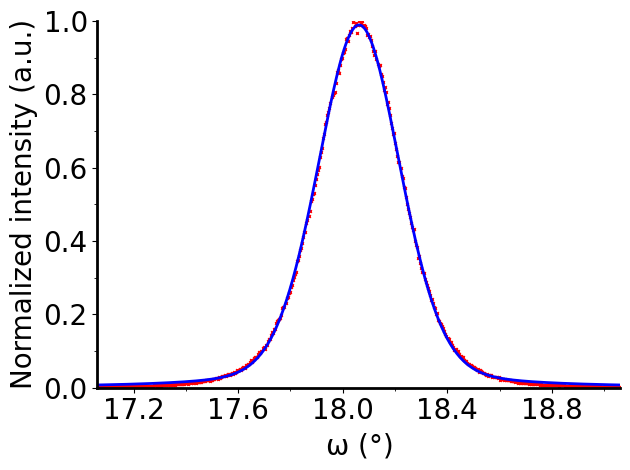

Rx: -0.0980, Ry: 0.0188
Offset Angle: 0.0998, Azimuth Angle: 169.1641
Omega: 14.22, Two Theta: 28.45, Beta: 0.01


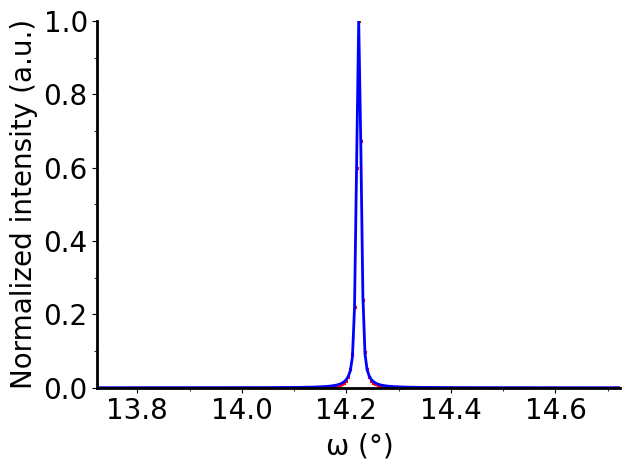

In [3]:
gan_hemt_on_silicon_fit = pseudo_voigt(
    '../data/raw/20250515_M3-AlGaN_AlN_0002.ras',
    normalized = True, verbose = True, plot = True,
)

gan_hemt_si111_fit = pseudo_voigt(
    '../data/raw/20250515_M3-AlGaN_Si_111.ras',
    normalized = True, verbose = True, plot = True,
)

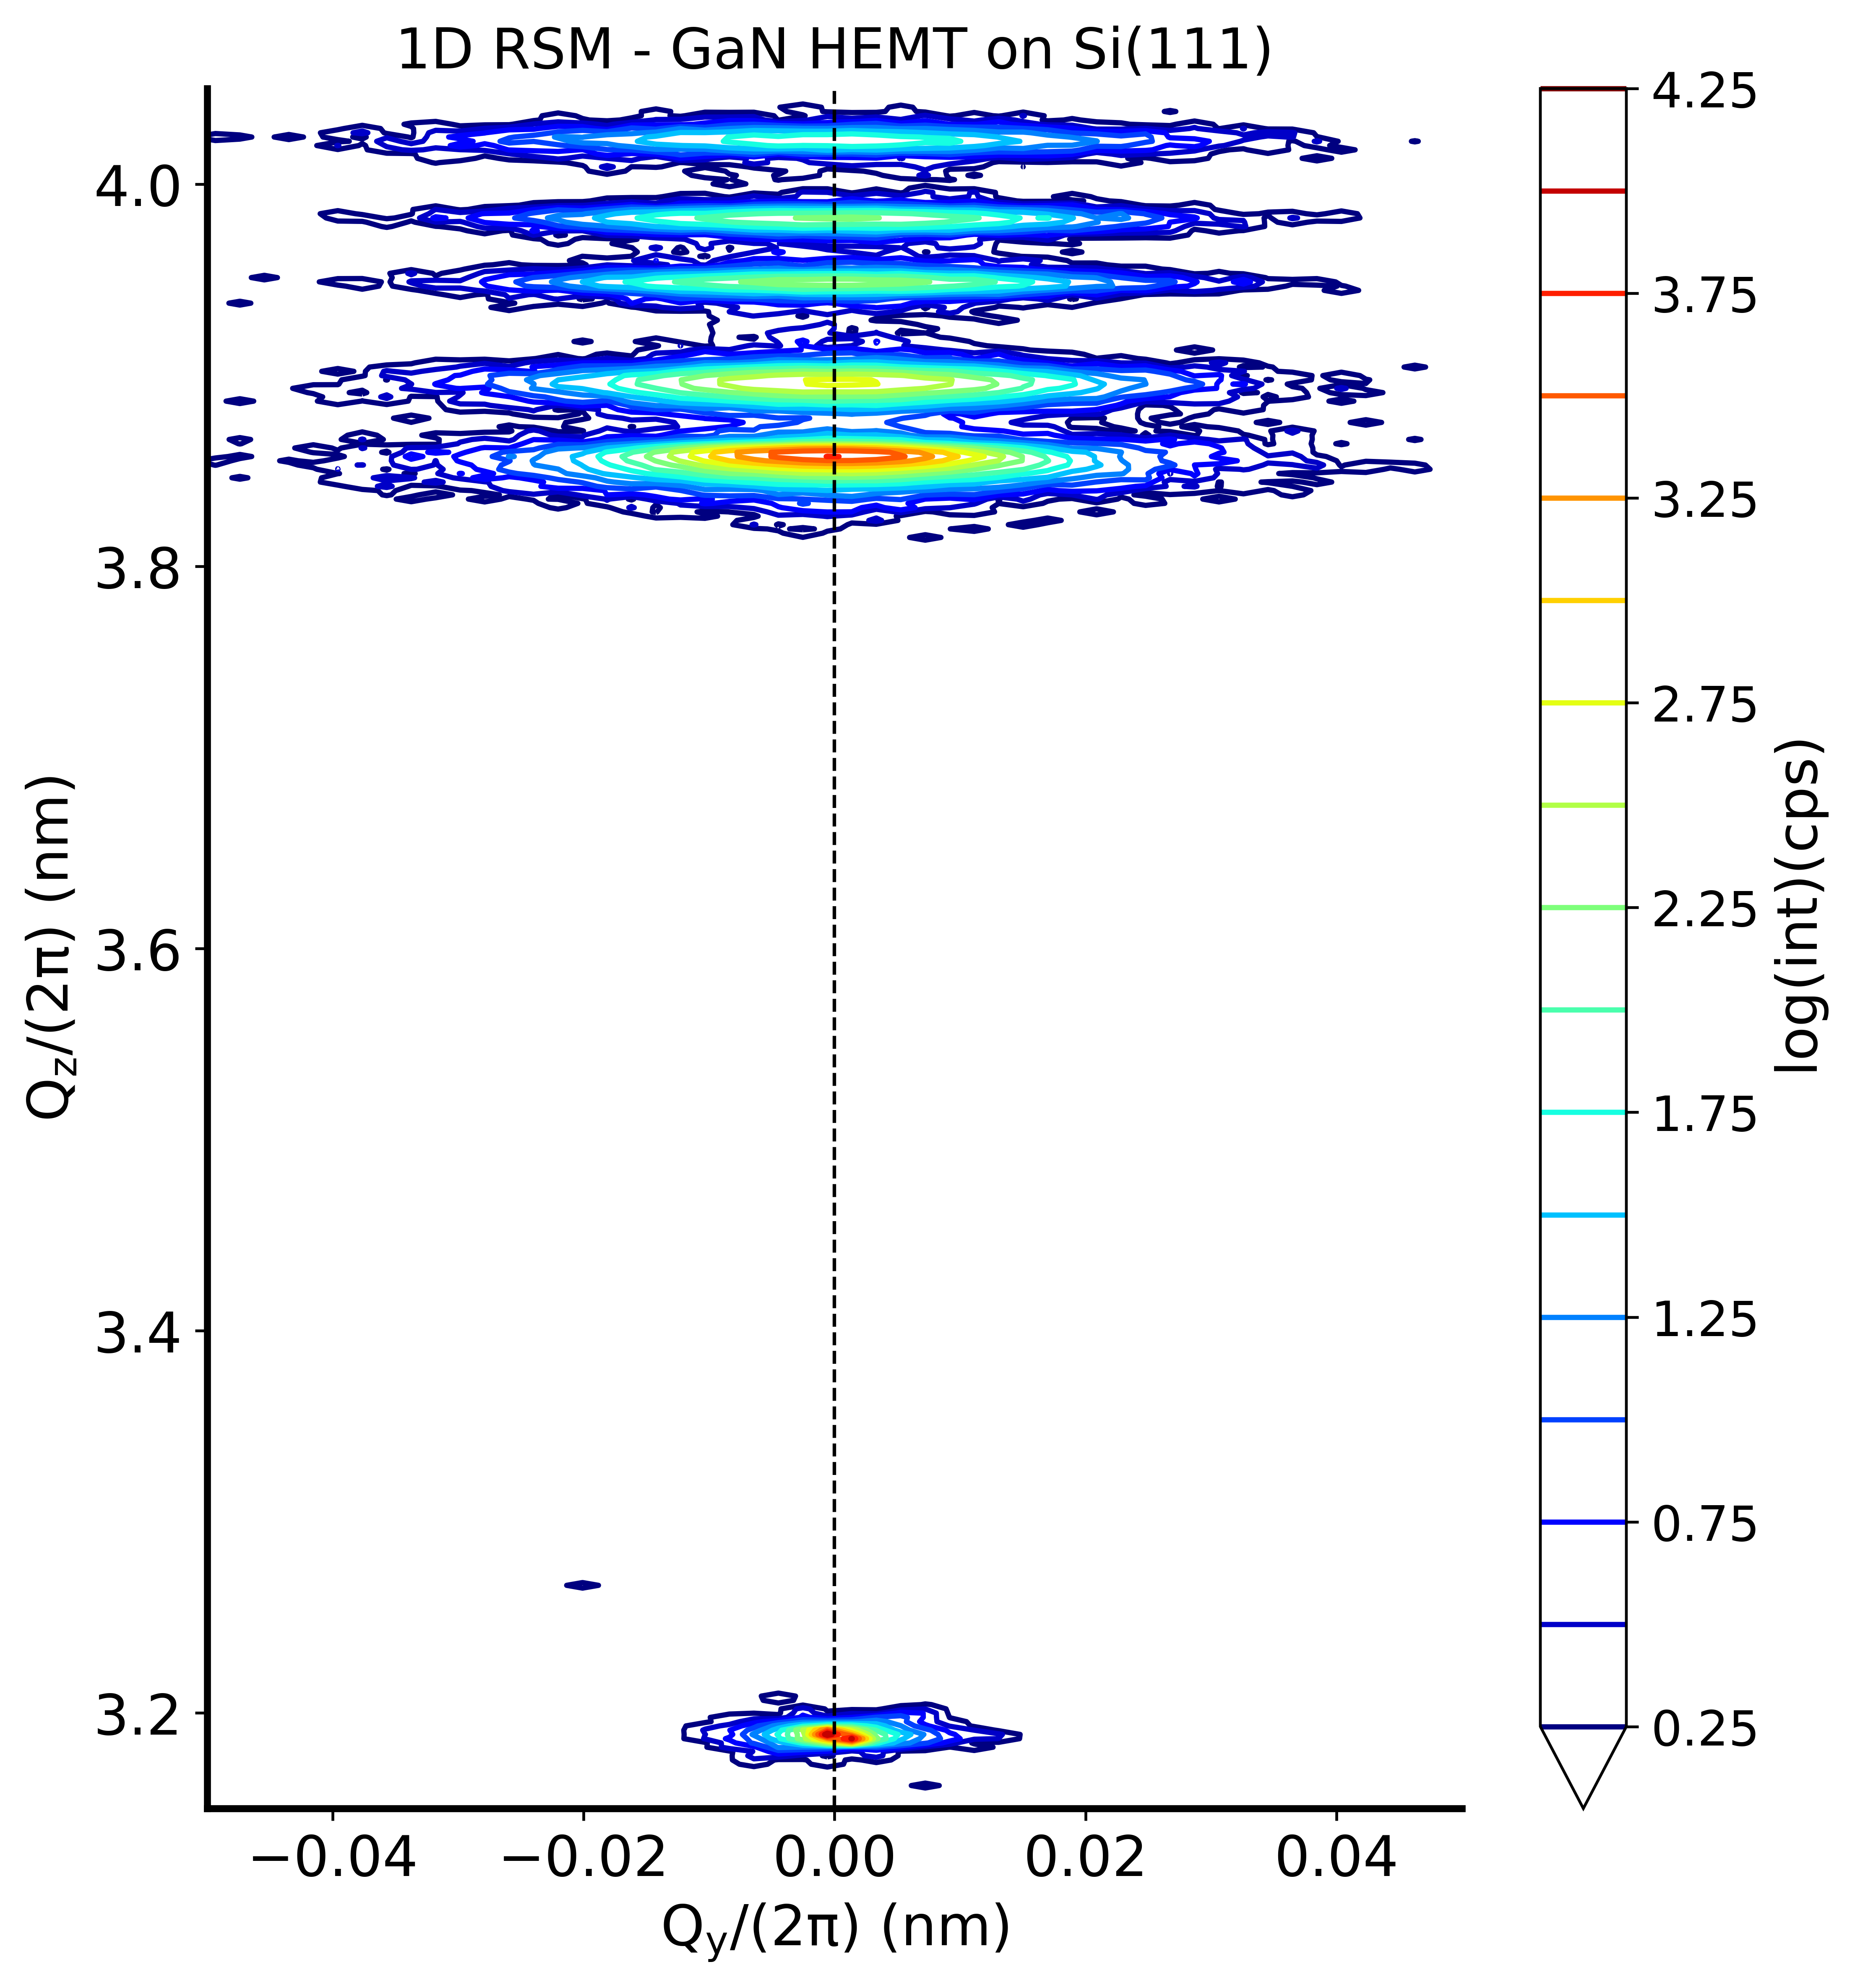

In [4]:
reciprocal_space_map_1D([
    '../data/raw/20250515_M3-AlGaN_RSM1D_Si_111_1.ras',
    '../data/raw/20250515_M3-AlGaN_RSM1D_Si_111_3.ras',
    ], use_rlu = True, levels = 15, xlim = (-0.05, 0.05),
    ylim = (3.15, 4.05), dyn_low = 4, dyn_high = -1, label_size = 16, 
    title = '1D RSM - GaN HEMT on Si(111)'
)

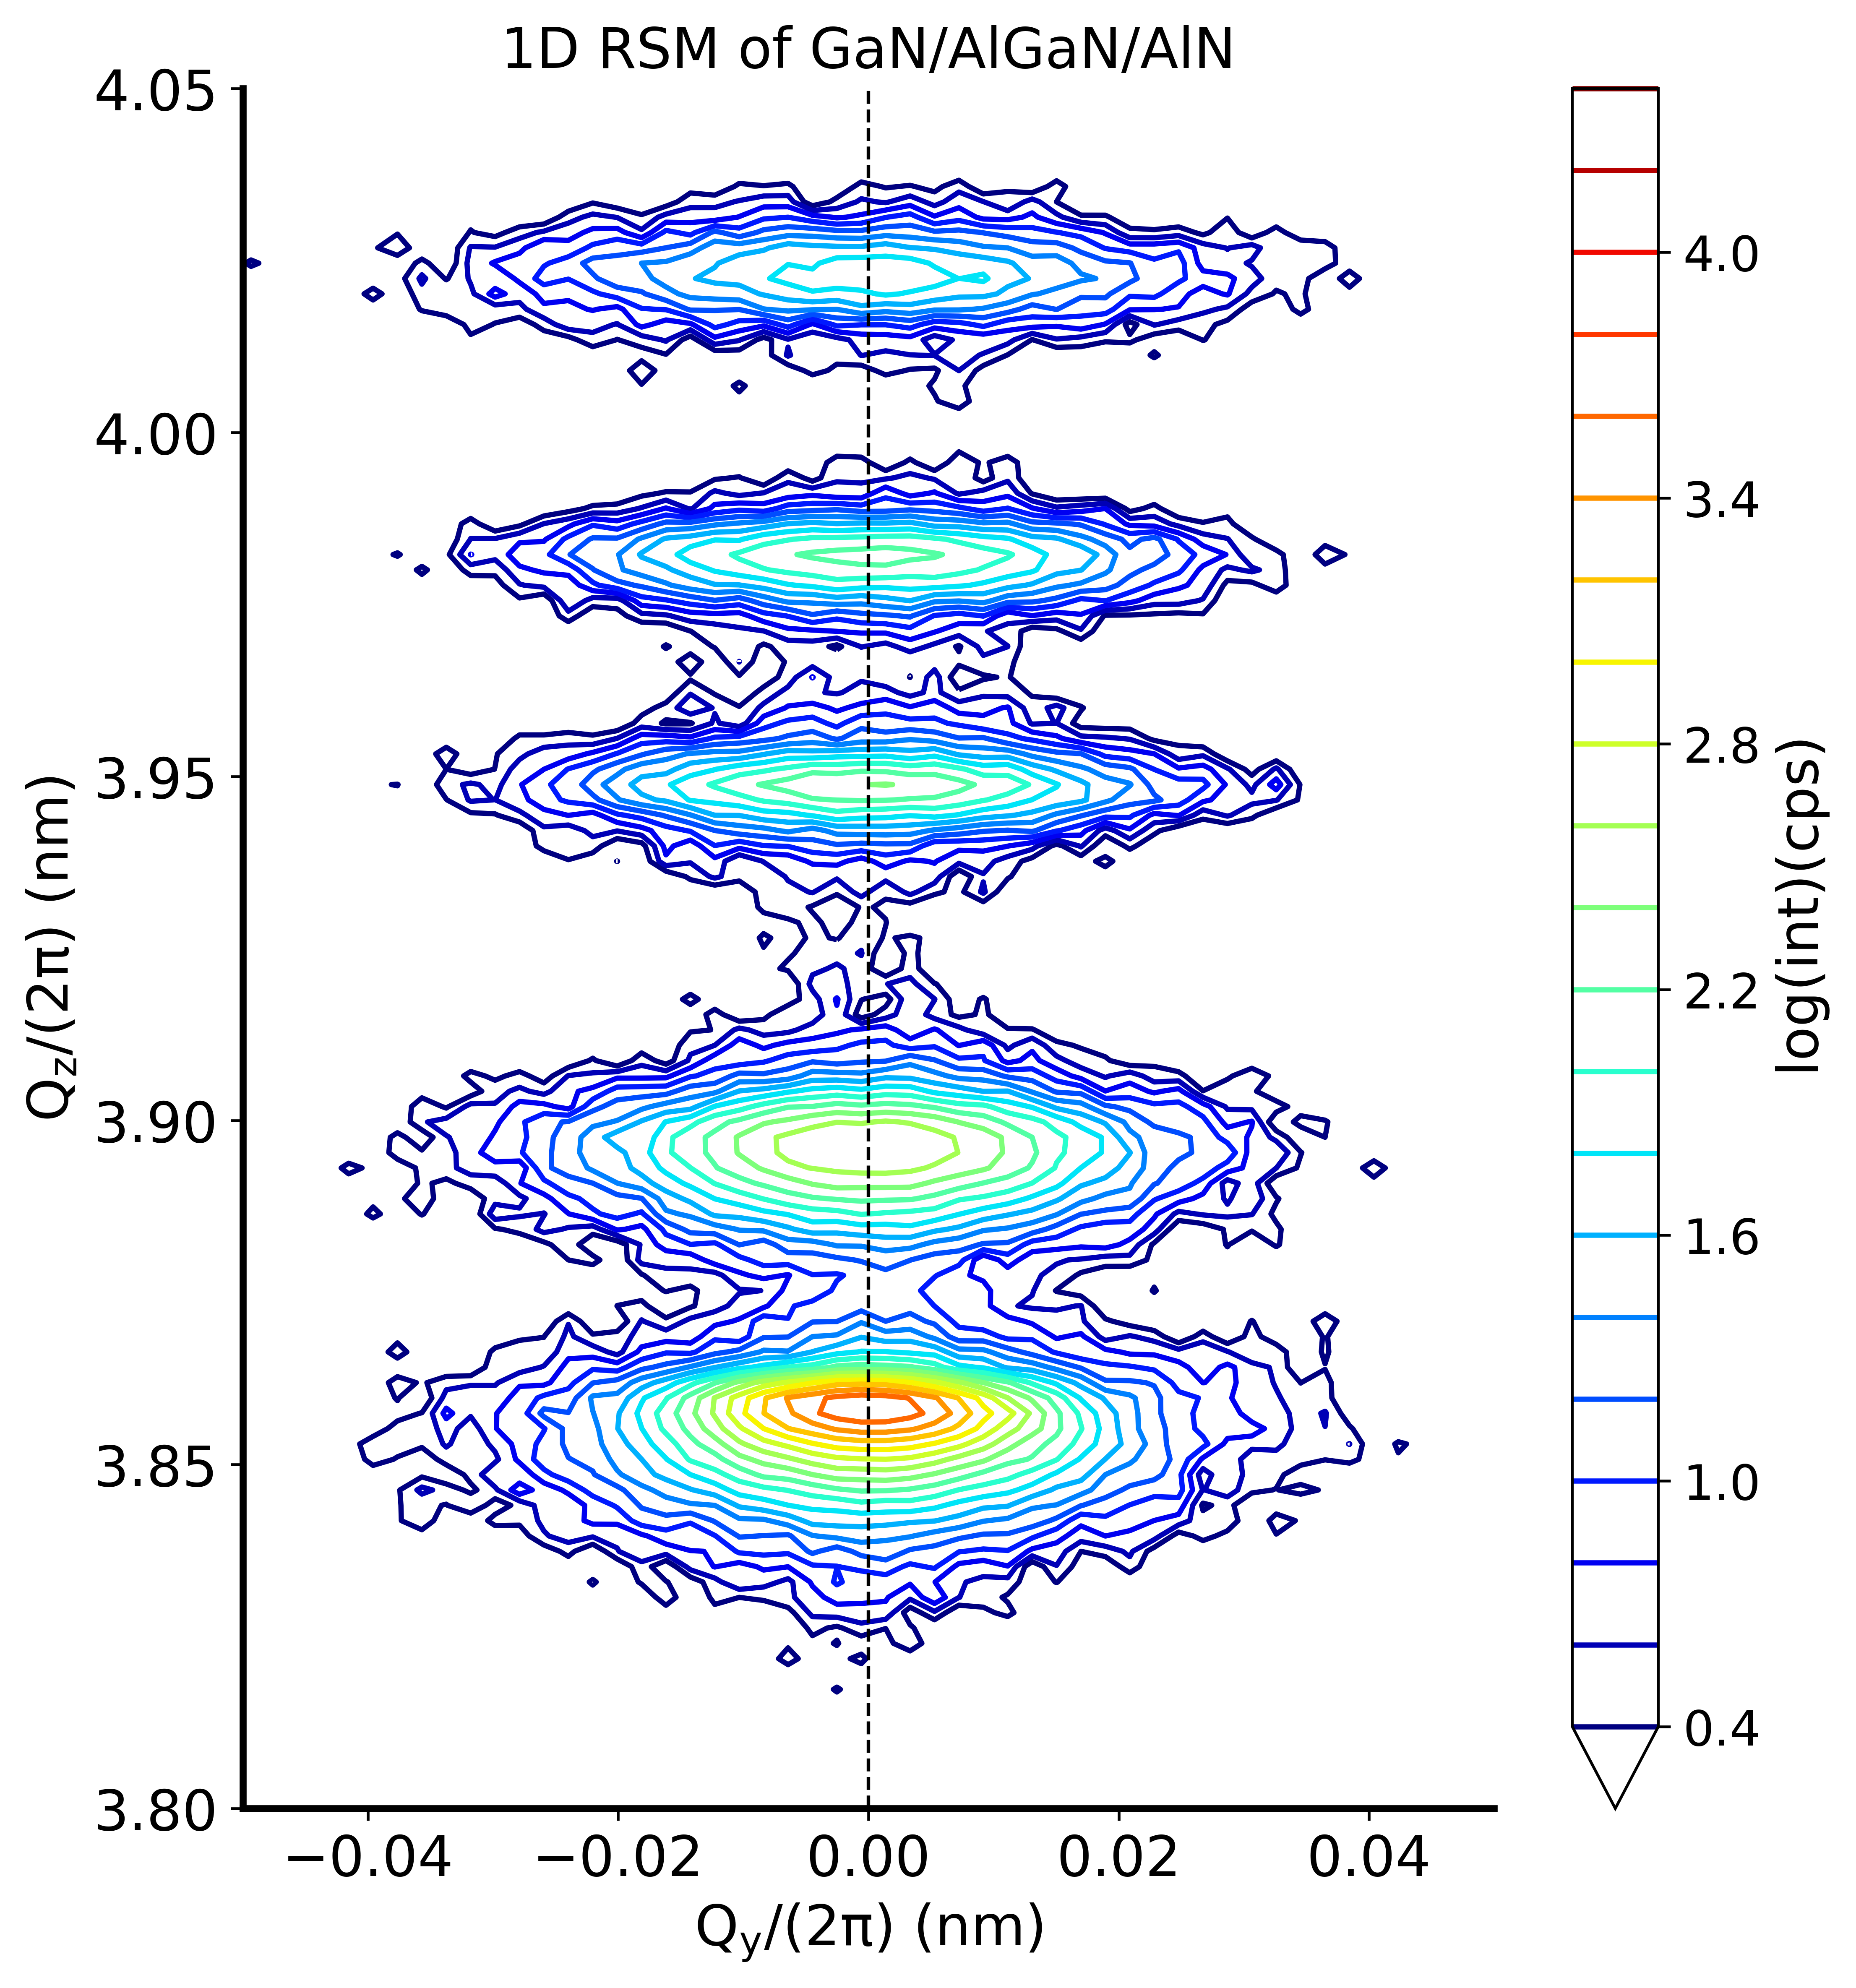

In [5]:
reciprocal_space_map_1D([
    '../data/raw/20250515_M3-AlGaN_RSM1D_Si_111_1.ras',
    '../data/raw/20250515_M3-AlGaN_RSM1D_Si_111_3.ras',
    ], use_rlu = True, levels = 25, xlim = (-0.05, 0.05),
    ylim = (3.8, 4.05), label_size = 16, 
    title = '1D RSM of GaN/AlGaN/AlN'
)